# Personalized Cancer Diagnosis

## [ CONTENTS ] 

1. About the dataset<br>
2. Real-world/Business objectives and constraints<br>
3. Data and Libraries Loading<br>
4. Exploratory Data Analysis
4. Data Preprocessing <br>
5. Naive Bayes on k-Fold cross validation<br>
6. Bag of Words (BoW)<br>
    6.1 Bi-Grams & N-Grams<br>
7. TF-IDF<br>
8. Summary<br>

## 1. About the dataset
1. **Title:** Personalized Cancer Diagnosis. Link:https://www.kaggle.com/c/msk-redefining-cancer-treatment/ 
2. **Data:** Memorial Sloan Kettering Cancer Center (MSKCC)
3. **Task:** Classify the given genetic variations/mutations based on evidence from text-based clinical literature.
4. **Relevant Info:** There are nine different classes a genetic mutation can be classified on. This is not a trivial task since interpreting clinical evidence is very challenging even for human specialists. Therefore, modeling the clinical evidence (text) will be critical.
5. **Data includes:**
    * **training_variants** - a comma separated file containing the description of the genetic mutations used for training. Fields are <i>ID</i> (the id of the row used to link the mutation to the clinical evidence), <i>Gene</i> (the gene where this genetic mutation is located), <i>Variation</i> (the amino-acid change for this mutations), <i>Class</i> (1-9 the class this genetic mutation has been classified on)
    * **training_text** - a double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. Fields are ID (the id of the row used to link the clinical evidence to the genetic mutation), Text (the clinical evidence used to classify the genetic mutation)

## 2. Real-world/Business objective and constraints


**Objective:** Classify the given genetic variations/mutations based on evidence from text-based clinical literature.
<br>
<br>**Constraints:**
<br>
* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

## 3. Data and Libraries Loading

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

In [2]:
data = pd.read_csv('training/training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [4]:
# note the seprator in this file
data_text =pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


## 4. Data Preprocessing

In [5]:
stop_words = set(stopwords.words('english')) 

def txt_preprocessing(total_txt, index, col):
    
    if type(total_txt) is not int:
        string = ''
        total_txt = re.sub('[^a-zA-Z0-9\n]', ' ', total_txt)
        total_txt = re.sub('\s+', ' ', total_txt)
        total_txt = total_txt.lower()
        
        for word in total_txt.split():
            if not word in stop_words:
                string += word + ' '
                
        data_text[col][index] = string

In [6]:
#txt_preprocessing runner 
tic = time.time()

for index, row in data_text.iterrows():
    
    if type(row['TEXT']) is str:
        txt_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)

print('Time took for preprocessing the text :', time.time() - tic, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 153.45820546150208 seconds


In [7]:
complete_data = pd.merge(data, data_text, on = 'ID', how = 'left')
complete_data.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [8]:
complete_data[complete_data['TEXT'].isnull()]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [9]:
complete_data['TEXT'][complete_data['TEXT'].isnull()] = complete_data['Gene'] +' '+complete_data['Variation']

In [10]:
complete_data[complete_data['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


In [11]:
y_true = complete_data['Class'].values
complete_data.Gene = complete_data.Gene.str.replace('\s+', '_')
complete_data.Variation = complete_data.Variation.str.replace('\s+', '_')

In [12]:
def data_split(complete_data, ytrue, tsize):
    
    train_x, test_x, train_y, test_y = train_test_split(complete_data, ytrue,
                                                        stratify = ytrue, test_size = tsize,
                                                        random_state = 21)
    if 'Class' in train_x.columns:
        train_x = train_x.drop(['Class'], axis = 1)
        test_x = test_x.drop(['Class'], axis = 1)
    
    return train_x, test_x, train_y, test_y

In [13]:
train_x, test_x, train_y, test_y = data_split(complete_data, y_true, 0.3)
test_x, crossv_x, test_y, crossv_y = data_split(test_x, test_y, 0.5)

In [75]:
print('Train set size : {0:10}'.format(len(train_x)))
print('Test set size : {0:10}'.format(len(test_x)))
print('Cross Validation set : {0:2}'.format(len(crossv_x)))

Train set size :       2324
Test set size :        498
Cross Validation set : 499


In [15]:
from sklearn.preprocessing import StandardScaler

#Standardizing the data
def standardizer(data):
    stnd_scaler = StandardScaler(with_mean=False)
    stnd_matx = stnd_scaler.fit_transform(data)
    return stnd_matx

In [16]:
from sklearn.preprocessing import MaxAbsScaler

def max_abs(data):
    maxabs = MaxAbsScaler()
    result = maxabs.fit_transform(data)
    return result

### 4.1 Categorical Variable Encoding

### [A] One Hot Encode

In [151]:
from sklearn.preprocessing import LabelBinarizer

def onehot_encode(fitter, convert, categories):
    
    encode = LabelBinarizer()
    fit_encoded = normalize(encode.fit_transform(fitter), axis = 0)
    encoded = normalize(encode.transform(convert), axis = 0)

    fit_encoded = pd.SparseDataFrame(fit_encoded, columns = categories).fillna(0)
    encoded = pd.SparseDataFrame(encoded, columns = categories).fillna(0)
    
    return fit_encoded, encoded

### [B] Response Encode

In [18]:
def feature_dictionary(data, ydata, feature, alpha):
    
    value_count = data[feature].value_counts()
    dict_format = dict()
    
    for i, j in value_count.items():
        vec = []
        for k in range(1, 10):
            class_count = data[(ydata == k) & (data[feature] == i)]
            vec.append((class_count.shape[0] + alpha * 90) / (j + 90 * alpha))
        dict_format[i] = vec
    
    return dict_format

def response_encode(trn_data, ydata, tst_data, feature, alpha):
    
    feature_dict = feature_dictionary(trn_data, ydata, feature, alpha)
    value_count = trn_data[feature].value_counts()
    trn_encoded = []
    
    for index, row in trn_data.iterrows():
        if row[feature] in dict(value_count).keys():
                trn_encoded.append(feature_dict[row[feature]])
        
        else:
                trn_encoded.append([1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9])
                
    tst_encoded = []
    
    for index, row in tst_data.iterrows():
        if row[feature] in dict(value_count).keys():
                tst_encoded.append(feature_dict[row[feature]])
        
        else:
                tst_encoded.append([1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9])
            
    return trn_encoded, tst_encoded

### 4.2 TEXT Encoding and Vectorization

In [19]:
import math

def text_response_encode(data, ydata, total_dict, dict_list):
    
    encoded = np.zeros((data.shape[0], 9))
        
    for i in range(0, 9):
        row_index = 0
        for index, row in data.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word, 0)+10) / (total_dict.get(word, 0) + 90)))
            encoded[row_index][i] = math.exp(sum_prob / len(row['TEXT'].split()))
            row_index += 1
    
    return encoded

In [107]:
def unique_words(data):
    
    text_vect = TfidfVectorizer(min_df = 3, stop_words = 'english')
    fit_vect = text_vect.fit(data['TEXT'])
    train_features = text_vect.get_feature_names()
    
    #train_feature_count = np.sum(fit_vect, axis = 0)
    #txt_feature_dict = dict(zip(list(train_features), train_feature_count))
    print('Total Number of Unique Words in Train Data : ', len(train_features))

In [157]:
def text_onehot_encode(train_data, test_data):
    
    text_vect = TfidfVectorizer(min_df = 3, stop_words = 'english', max_features = 1000)
    fit_vect = text_vect.fit(train_data['TEXT'])
    train_vect = fit_vect.transform(train_data['TEXT'])
    test_vect = fit_vect.transform(test_data['TEXT'])
    features = text_vect.get_feature_names()
    
    train_vect = normalize(train_vect, axis=0)
    test_vect = normalize(test_vect, axis=0)

    where_are_NaNs = pd.isnull(train_vect)
    train_vect[where_are_NaNs] = 0
    where_are_NaNs = pd.isnull(test_vect)
    test_vect[where_are_NaNs] = 0
    
    train_vect = pd.SparseDataFrame(train_vect, columns = features).fillna(0)
    test_vect = pd.SparseDataFrame(test_vect, columns = features).fillna(0)
    
    return train_vect, test_vect

In [22]:
def something(data, labels):
    
    train_x, test_x, train_y, test_y = data_split(data, labels)
    dict_list = []
    for i in range(1, 10):
        cls_text = train_x[train_y == i]
        dict_list.append(extract_dic(cls_text))

    total_dict = extract_dic(train_x['TEXT'])

    confuse_array = []
    for i in train_text_features:
        ratios = []
        max_val = -1
        for j in range(0,9):
            ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
        confuse_array.append(ratios)
    confuse_array = np.array(confuse_array)

## 5. Exploratory Data Analysis 

In [23]:
def distribution_check(data, name):
    classes = np.unique(data)
    freq_counts = []
    print('Class Distribution for {}:'.format(name))
    for c in classes:
        class_count = np.array(data == c).sum()
        freq_counts.append(class_count)
    for i, c in enumerate(list(classes)):
        print('Number of Data Points in Class {} is {} ({}%)'.format(classes[i],
                                                                     freq_counts[i],
                                                                     np.round(freq_counts[i] * 100 / len(data))))
    distribution_plot(classes, freq_counts, name)

In [24]:
def distribution_plot(classes, freq_counts, name):
    sns.set()
    my_color = 'RdPu'
    plt.figure(figsize=(8, 5))
    sns.barplot(x = classes, y = freq_counts, alpha = 1)
    plt.title('Class Distribution plot for {}'.format(name))
    plt.xlabel('Class Labels')
    plt.ylabel('Count')
    plt.show()

Class Distribution for Train Set:
Number of Data Points in Class 1 is 398 (17.0%)
Number of Data Points in Class 2 is 316 (14.0%)
Number of Data Points in Class 3 is 62 (3.0%)
Number of Data Points in Class 4 is 480 (21.0%)
Number of Data Points in Class 5 is 169 (7.0%)
Number of Data Points in Class 6 is 193 (8.0%)
Number of Data Points in Class 7 is 667 (29.0%)
Number of Data Points in Class 8 is 13 (1.0%)
Number of Data Points in Class 9 is 26 (1.0%)


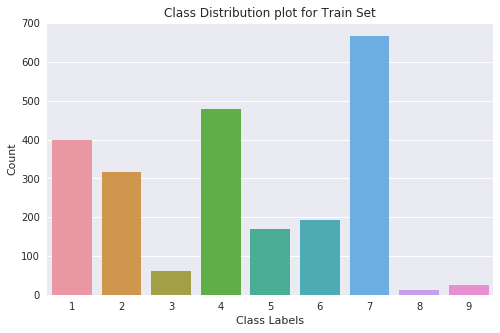

In [25]:
distribution_check(train_y, 'Train Set')

Class Distribution for Test Set:
Number of Data Points in Class 1 is 85 (17.0%)
Number of Data Points in Class 2 is 68 (14.0%)
Number of Data Points in Class 3 is 13 (3.0%)
Number of Data Points in Class 4 is 103 (21.0%)
Number of Data Points in Class 5 is 36 (7.0%)
Number of Data Points in Class 6 is 41 (8.0%)
Number of Data Points in Class 7 is 143 (29.0%)
Number of Data Points in Class 8 is 3 (1.0%)
Number of Data Points in Class 9 is 6 (1.0%)


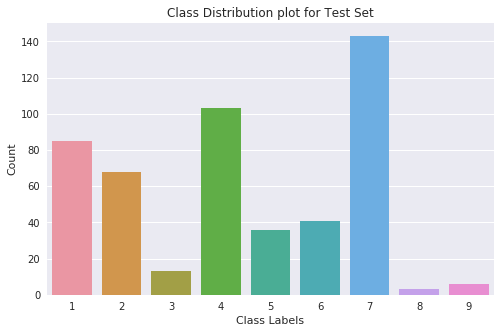

In [26]:
distribution_check(test_y, 'Test Set')

Class Distribution for Cross-Validation Set:
Number of Data Points in Class 1 is 85 (17.0%)
Number of Data Points in Class 2 is 68 (14.0%)
Number of Data Points in Class 3 is 14 (3.0%)
Number of Data Points in Class 4 is 103 (21.0%)
Number of Data Points in Class 5 is 37 (7.0%)
Number of Data Points in Class 6 is 41 (8.0%)
Number of Data Points in Class 7 is 143 (29.0%)
Number of Data Points in Class 8 is 3 (1.0%)
Number of Data Points in Class 9 is 5 (1.0%)


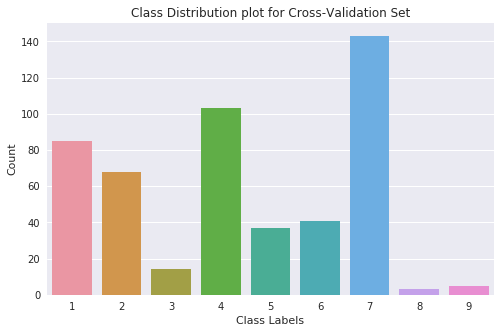

In [27]:
distribution_check(crossv_y, 'Cross-Validation Set')

### 5.1 Univariate Analysis 

In [28]:
def dist_plot(data, feature):
    
    sns.set()
    plt.figure(figsize = (10, 5))
    sns.distplot(data.values, color = 'b')
    plt.xlabel('Index of Gene')
    plt.ylabel('Num of Occurrence')
    plt.title('Distribution Plot for ' + feature)
    plt.show()
    
    plt.figure(figsize = (10, 5))
    plt.plot(np.cumsum(data.values / sum(data.values)), color = 'b')
    plt.xlabel('Index of Gene')
    plt.ylabel('Cumulative Sum')
    plt.title('Cumulative Distribuition of ' + feature)
    plt.show()  

### [A] Gene

In [29]:
unique_genes = train_x['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
unique_genes.head(10)

Number of Unique Genes : 240


BRCA1     186
TP53      117
EGFR      100
BRCA2      92
PTEN       84
BRAF       69
KIT        64
ERBB2      48
ALK        43
PIK3CA     41
Name: Gene, dtype: int64

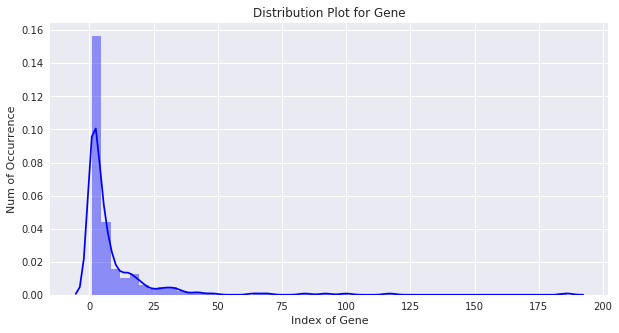

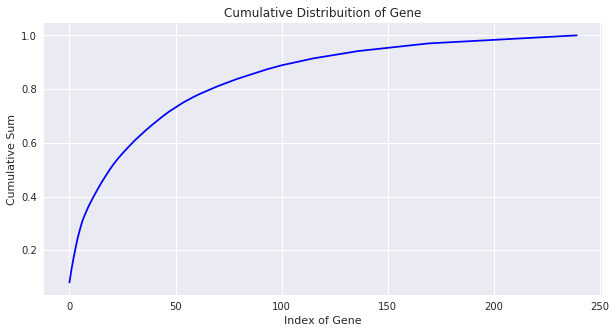

In [30]:
dist_plot(unique_genes, 'Gene')

### [B] Variation

In [31]:
unique_genes = train_x['Variation'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
unique_genes.head(10)

Number of Unique Genes : 2109


Truncating_Mutations    72
Amplification           50
Deletion                48
Fusions                 19
Overexpression           4
G12V                     4
E17K                     3
Q61L                     2
T167A                    2
Q61H                     2
Name: Variation, dtype: int64

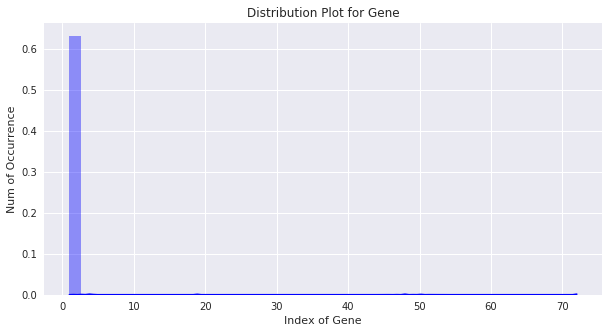

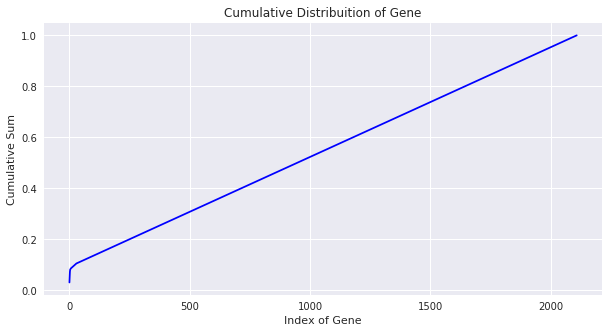

In [32]:
dist_plot(unique_genes, 'Gene')

In [33]:
def extract_dict(data):
    
    dictionary = defaultdict(int)
    for index, row in data.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] += 1
    
    return dictionary

In [109]:
unique_words(train_x)

Total Number of Unique Words in Train Data :  55679


## 6. Prediction using a 'Random' Model 

In [35]:
def random_clf(ytrain, ytest):

    ytrain_dummy = np.zeros((1, len(np.unique(ytrain))))
    ytest_dummy = np.zeros((1, len(np.unique(ytest))))
    
    for i in range(len(ytrain)):
        random_probs = np.random.rand(1, len(np.unique(ytrain)))
        ytrain_dummy = np.vstack([ytrain_dummy, random_probs / random_probs.sum()])
    print('Log-Loss on Train-set using Random Model is ', log_loss(ytrain, ytrain_dummy[1:, :]))
    err_metrics(ytrain, np.argmax(ytrain_dummy[1:, :], axis = 1) + 1)
        
    for i in range(len(ytest)):
        random_probs = np.random.rand(1, len(np.unique(ytest)))
        ytest_dummy = np.vstack([ytest_dummy, random_probs / random_probs.sum()])
    print('Log-Loss on Test-set using Random Model is ', log_loss(ytest, ytest_dummy[1:, :]))
    err_metrics(ytest, (np.argmax(ytest_dummy[1:, :], axis = 1)) + 1)

In [37]:
def err_metrics(y, yhat):
    
    confuzn_mtx = confusion_matrix(y, yhat)
    precision_mtx = confuzn_mtx / confuzn_mtx.sum(axis = 0)
    recall_mtx = (confuzn_mtx.T / confuzn_mtx.sum(axis = 1)).T
    labels = np.unique(y)
    
    print('-'*40, 'CONFUSION-MATRIX', '-'*40)
    plt.figure(figsize=(18, 7))
    sns.heatmap(confuzn_mtx, annot=True, cmap="magma", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print('-'*40, 'PRECISION-MATRIX', '-'*40)
    plt.figure(figsize=(18, 7))
    sns.heatmap(precision_mtx, annot=True, cmap="magma", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print('-'*40, 'RECALL-MATRIX', '-'*40)
    plt.figure(figsize=(18, 7))
    sns.heatmap(recall_mtx, annot=True, cmap="magma", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log-Loss on Train-set using Random Model is  2.4361112873209296
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


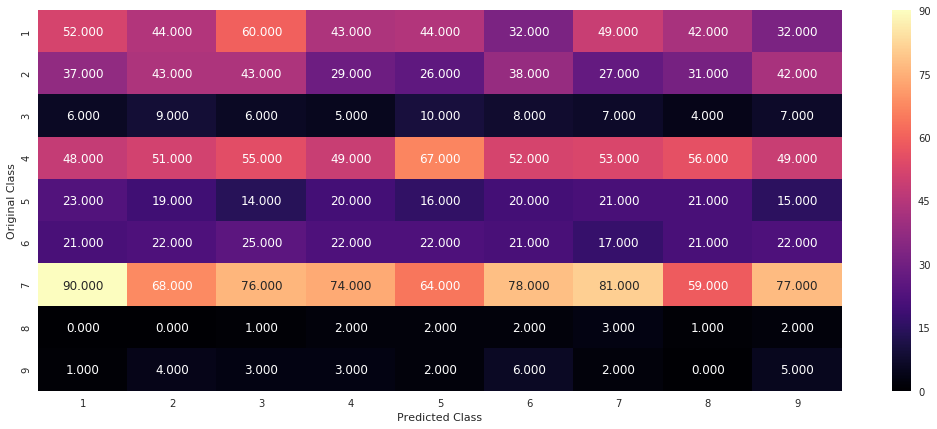

---------------------------------------- PRECISION-MATRIX ----------------------------------------


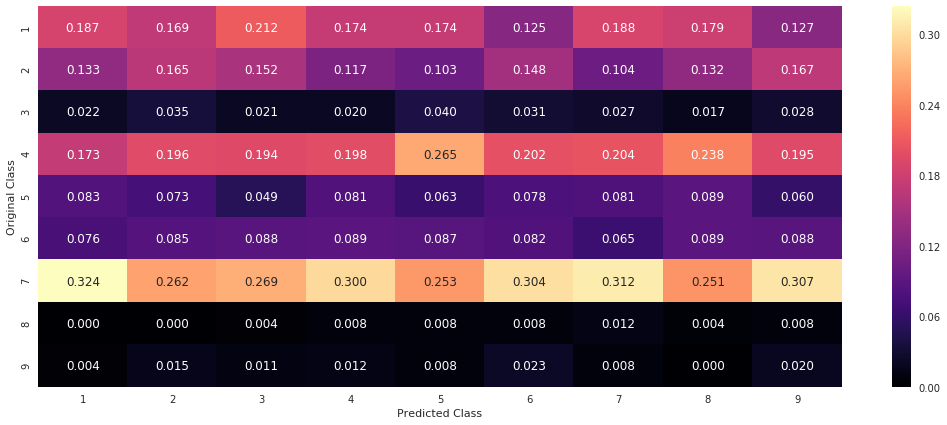

---------------------------------------- RECALL-MATRIX ----------------------------------------


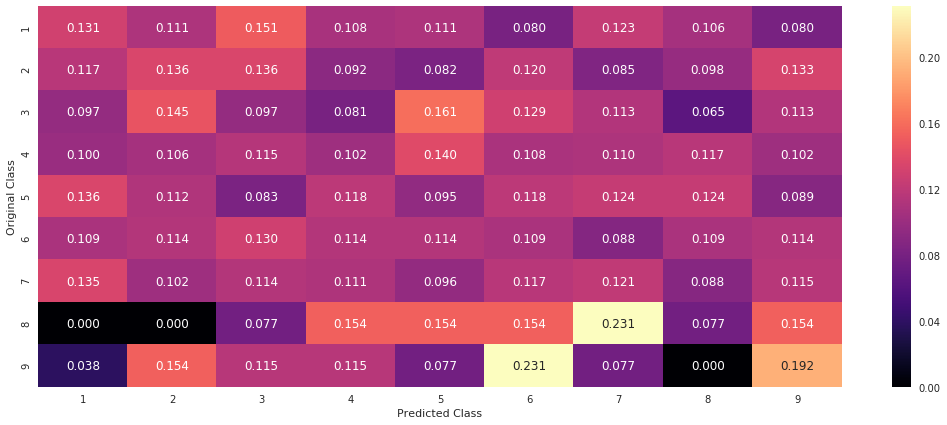

Log-Loss on Test-set using Random Model is  2.533692353749892
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


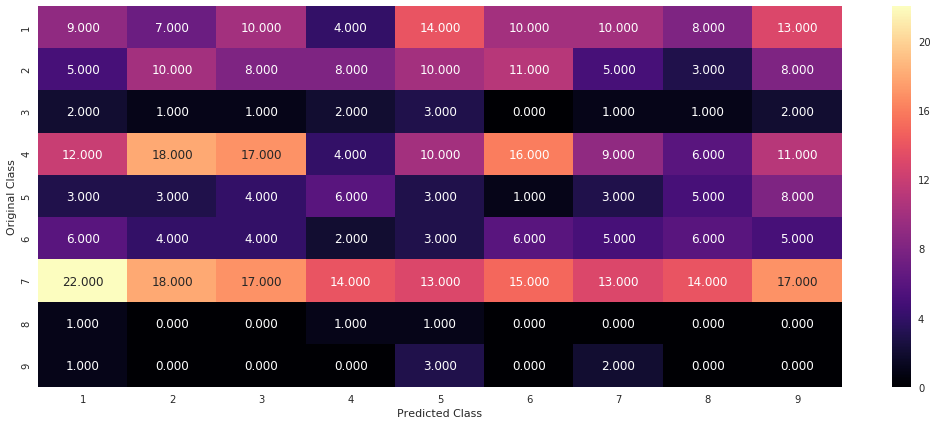

---------------------------------------- PRECISION-MATRIX ----------------------------------------


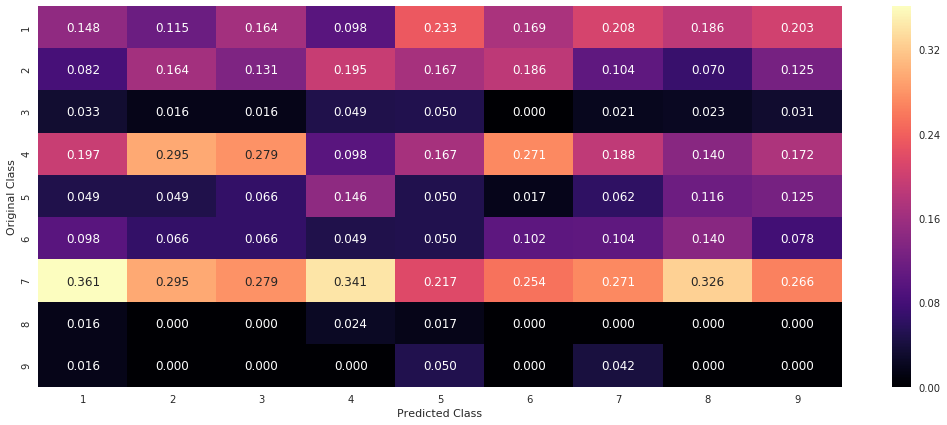

---------------------------------------- RECALL-MATRIX ----------------------------------------


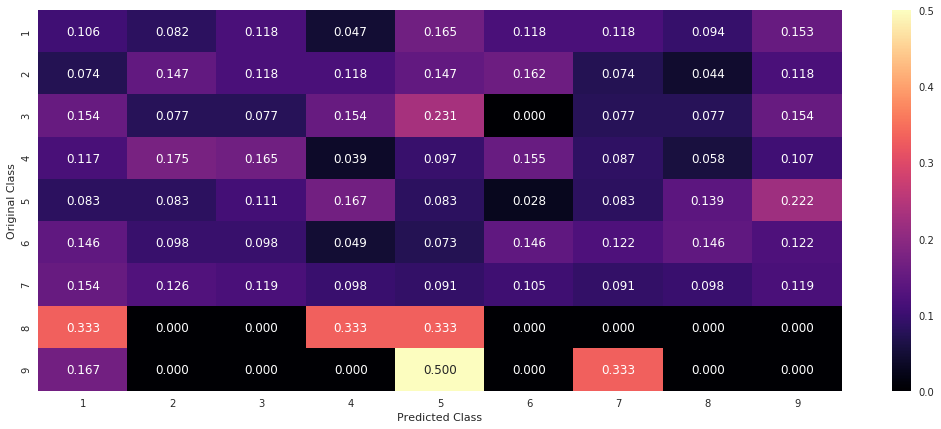

In [38]:
random_clf(train_y, test_y)

## 7. Feature Importance 

In [54]:
def feature_importance(feature, encode_type, operation, best_alpha = None):
    
    alpha = [10 ** x for x in range(-5, 1)]
    logloss_trn = []
    logloss_cv = []

    if operation == 'Training' and feature != 'TEXT':
        for i in alpha:
                
            if encode_type == 'OneHotEncode':
                trn_x, cv_x = onehot_encode(train_x[feature], crossv_x[feature], np.unique(train_x[feature]))
            else:
                trn_x, cv_x = response_encode(train_x, train_y, crossv_x, feature, 1)
    
            clf = SGDClassifier(alpha = i, penalty = 'l2', loss = 'log', random_state = 32)
            clf.fit(trn_x, train_y)
            
            trn_predproba = clf.predict_proba(trn_x)
            cv_predproba = clf.predict_proba(cv_x)
            
            logloss_trn.append(log_loss(train_y, trn_predproba))
            logloss_cv.append(log_loss(crossv_y, cv_predproba))
        
        err_curve_sgd(logloss_trn, logloss_cv, alpha)
    
    elif operation == 'Testing' and feature != 'TEXT':
        if encode_type == 'OneHotEncode':
            trn_x, tst_x = onehot_encode(train_x[feature], test_x[feature], np.unique(train_x[feature]))
        else:
            trn_x, tst_x = response_encode(train_x, train_y, test_x, feature, 0.0001)
    
        clf = SGDClassifier(alpha = best_alpha, penalty = 'l2', loss = 'log', random_state = 32)
        clf.fit(trn_x, train_y)
        
        trn_predproba = clf.predict_proba(trn_x)
        tst_predproba = clf.predict_proba(tst_x)

        print('Log-Loss For Train-Set is :', log_loss(train_y, trn_predproba))
        print('Log-Loss For Test-set is  :', log_loss(test_y, tst_predproba))
        
    elif operation == 'Training' and feature == 'TEXT':
        for i in alpha:
                
                if encode_type == 'OneHotEncode':
                    trn_x, cv_x = text_onehot_encode(train_x, crossv_x)
                else:
                    total_dict = extract_dict(train_x)
                    dict_list = []
    
                    for i in range(1,10):
                        cls_text = train_x[train_y == i]
                        dict_list.append(extract_dict(cls_text))
                
                    trn_x = text_response_encode(train_x, train_y,
                                                 total_dict, dict_list)
                    cv_x = text_response_encode(crossv_x, crossv_y,
                                                 total_dict, dict_list)
    
                clf = SGDClassifier(alpha = i, penalty = 'l2', loss = 'log', random_state = 32)
                clf.fit(trn_x, train_y)
            
                trn_predproba = clf.predict_proba(trn_x)
                cv_predproba = clf.predict_proba(cv_x)
                
                trn_predproba = np.nan_to_num(trn_predproba)
                cv_predproba = np.nan_to_num(cv_predproba)
            
                logloss_trn.append(log_loss(train_y, trn_predproba))
                logloss_cv.append(log_loss(crossv_y, cv_predproba))
        
        err_curve_sgd(logloss_trn, logloss_cv, alpha)
        
    else:
        if encode_type == 'OneHotEncode':
            trn_x, tst_x = text_onehot_encode(train_x, test_x)
        else:
            total_dict = extract_dict(train_x)
            dict_list = []
        
            for i in range(1,10):
                cls_text = train_x[train_y == i]
                dict_list.append(extract_dict(cls_text))
        
            trn_x = text_response_encode(train_x, train_y,
                                         total_dict, dict_list)
            tst_x = text_response_encode(test_x, test_y,
                                         total_dict, dict_list)
    
        clf = SGDClassifier(alpha = best_alpha, penalty = 'l2', loss = 'log', random_state = 32)
        clf.fit(trn_x, train_y)
        
        trn_predproba = clf.predict_proba(trn_x)
        tst_predproba = clf.predict_proba(tst_x)
        
        trn_predproba = np.nan_to_num(trn_predproba)
        tst_predproba = np.nan_to_num(tst_predproba)

        print('Log-Loss For Train-Set is :', log_loss(train_y, trn_predproba))
        print('Log-Loss For Test-set is  :', log_loss(test_y, tst_predproba))

In [43]:
def err_curve_sgd(train_loss, cv_loss, alpha):
    
    plt.figure(1)
    plt.figure(figsize = (8, 5))
    plt.plot(alpha, cv_loss, label = 'cv_error', color = 'r')
    plt.plot(alpha, train_loss, label = 'train_error', color = 'b')
    plt.xscale('log')
    plt.xlabel('Alpha-Values')
    plt.ylabel('Error Values')
    plt.legend()
    plt.title('CV & TRAIN-ERR')
    plt.show()

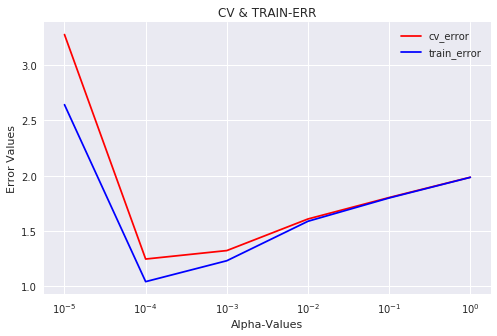

In [44]:
feature_importance('Gene', 'OneHotEncode', 'Training')

In [45]:
feature_importance('Gene', 'OneHotEncode', 'Testing', 0.0001)

Log-Loss For Train-Set is : 1.0393502663621332
Log-Loss For Test-set is  : 1.2292406981858264


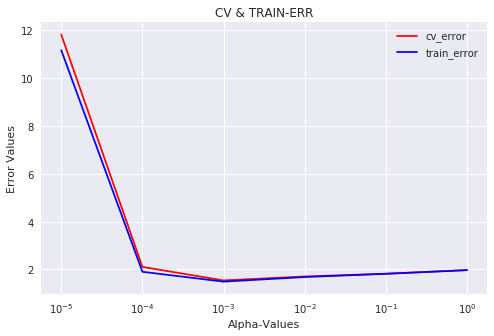

In [46]:
feature_importance('Gene', 'ResponseEncode', 'Training')

In [47]:
feature_importance('Gene', 'ResponseEncode', 'Testing', 0.0001)

Log-Loss For Train-Set is : 1.0290205940606927
Log-Loss For Test-set is  : 1.2541481808529609


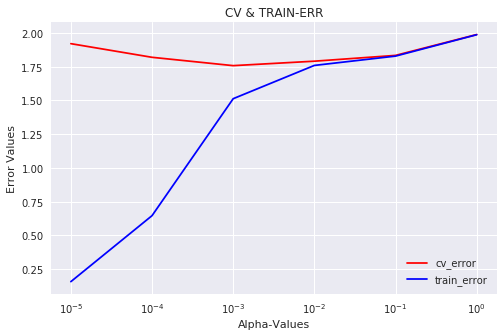

In [48]:
feature_importance('Variation', 'OneHotEncode', 'Training')

In [49]:
feature_importance('Variation', 'OneHotEncode', 'Testing', 0.01)

Log-Loss For Train-Set is : 1.7593752246914058
Log-Loss For Test-set is  : 1.7859694195399305


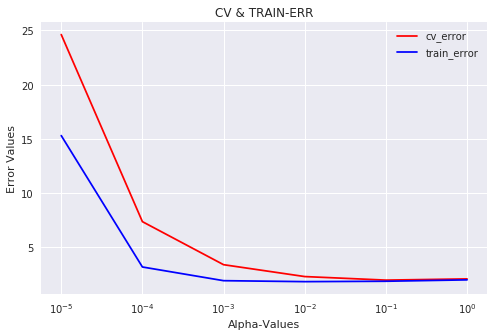

In [50]:
feature_importance('Variation', 'ResponseEncode', 'Training')

In [52]:
feature_importance('Variation', 'ResponseEncode', 'Testing', 0.1)

Log-Loss For Train-Set is : 1.2164729804651275
Log-Loss For Test-set is  : 1.7988225517881926


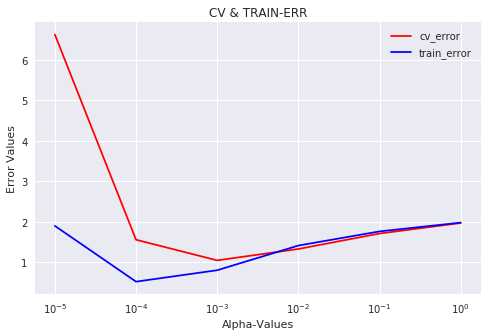

In [144]:
feature_importance('TEXT', 'OneHotEncode', 'Training')

In [145]:
feature_importance('TEXT', 'OneHotEncode', 'Testing', 0.001)

Log-Loss For Train-Set is : 0.8052837291489218
Log-Loss For Test-set is  : 1.0233286291897588


## 8. Machine Learning Models

### [A] Stacking All Features

In [153]:
def feature_stack(trn_data, trn_ydata, tst_data, tst_ydata, encode_type):
    
    if encode_type == 'OneHotEncode':
        
        gene_cat = np.unique(trn_data['Gene'])
        var_cat = np.unique(trn_data['Variation'])
        trn_gene, tst_gene = onehot_encode(trn_data['Gene'], tst_data['Gene'], gene_cat)
        trn_var, tst_var = onehot_encode(trn_data['Variation'], tst_data['Variation'], var_cat)
        trn_txt, tst_txt = text_onehot_encode(trn_data, tst_data)
        
        #print(trn_gene.shape, trn_var.shape, trn_txt.shape)
        total_trn_data = pd.concat([trn_gene, trn_var], axis = 1)
        total_trn_data = pd.concat([total_trn_data, trn_txt], axis = 1)
        total_tst_data = pd.concat([tst_gene, tst_var], axis = 1)
        total_tst_data = pd.concat([total_tst_data, tst_txt], axis = 1)
        
    else:
        total_dict = extract_dict(trn_data)
        dict_list = []
        
        for i in range(1,10):
            cls_text = trn_data[trn_ydata == i]
            dict_list.append(extract_dict(cls_text))
        
        trn_gene, tst_gene = response_encode(trn_data, trn_ydata, tst_data, 'Gene', 100000)
        trn_var, tst_var = response_encode(trn_data, trn_ydata, tst_data, 'Variation', 100000)
        trn_txt = text_response_encode(trn_data, trn_ydata, total_dict, dict_list)
        tst_txt = text_response_encode(tst_data, tst_ydata, total_dict, dict_list)
        
        total_trn_data = normalize(np.hstack([trn_gene, trn_var, trn_txt]), axis = 0)
        total_tst_data = normalize(np.hstack([tst_gene, tst_var, tst_txt]), axis = 0)
        
    return total_trn_data, total_tst_data

### 8.1 Naive Bayes

In [58]:
def naive_bayes_model(operation, encode_type, best_alpha = None):
    
    alpha = [0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100,500,1000,5000,10000]
    if operation == 'Training':
        cv_err = []
        train_err = []
        if encode_type == 'OneHotEncode':
            trn_data, cv_data = feature_stack(train_x, train_y, crossv_x, crossv_y, encode_type)
        else:
            trn_data, cv_data = feature_stack(train_x, train_y, crossv_x, crossv_y, encode_type)
        for a in alpha:
            clf = MultinomialNB(alpha = a, fit_prior = False)
            clf.fit(trn_data, train_y)
            pred_proba_trn = clf.predict_proba(trn_data)
            pred_proba_cv = clf.predict_proba(cv_data)
            train_err.append(log_loss(train_y, pred_proba_trn))
            cv_err.append(log_loss(crossv_y, pred_proba_cv))
        err_compare(train_err, cv_err, alpha, 'Alpha')
    else:
        clf = MultinomialNB(best_alpha, fit_prior = False)
        if encode_type == 'OneHotEncode':
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type)
        else:
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type)
        clf.fit(trn_data, train_y)
        pred_proba_trn = clf.predict_proba(trn_data)
        pred_proba_tst = clf.predict_proba(tst_data)
        trn_err = (1 - clf.score(trn_data, train_y))
        tst_err = (1 - clf.score(tst_data, test_y))
        print('Log-Loss for Train-set is :', log_loss(train_y, pred_proba_trn))
        print('Log-Loss for Test-set is :', log_loss(test_y, pred_proba_tst))
        print('Train Accuracy is :', trn_err)
        print('Test Accuracy is :', tst_err)
        err_metrics(test_y, clf.predict(tst_data))

In [99]:
def nb_query(best_alpha, query_indx):

    trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, 'OneHotEncode')
    clf = MultinomialNB(best_alpha, fit_prior = False)
    clf.fit(trn_data, train_y)
    num_feature = 100
    pred_cls = clf.predict(tst_data.iloc[query_indx].reshape(1, -1))
    print('Predicted Class : ', pred_cls[0])
    print('Actual Class : ', test_y[query_indx])
    print("-"*40)
    sorted_indices = (-clf.feature_log_prob_[pred_cls - 1]).argsort()[:, :num_feature]
    imp_features = np.take(tst_data.columns, sorted_indices)
    for indices in sorted_indices:
        for i in indices:
            if tst_data.columns[i] in np.unique(train_x['Gene']):
                print('Feature from Gene :', tst_data.columns[i], tst_data[tst_data.columns[i]][query_indx])
            elif tst_data.columns[i] in np.unique(train_x['Variation']):
                print('Feature from Variation :', tst_data.columns[i], tst_data[tst_data.columns[i]][query_indx])
            else:
                print('Feature from TEXT',tst_data.columns[i], tst_data[tst_data.columns[i]][query_indx])
    present_word = []
    for indices in sorted_indices:
        for i in indices:
            if tst_data.columns[i] in test_x['TEXT'].iloc[query_indx]:
                present_word.append(tst_data.columns[i])
    print('These Texts are present in the given query : ')
    print(present_word)

In [59]:
def err_compare(train_err, cv_err, hyp_param, param_name):
    sns.set()
    plt.figure(1)
    plt.figure(figsize=(8, 5))
    plt.plot(hyp_param, cv_err, label = 'cv_error', color = 'r')
    plt.plot(hyp_param, train_err, label = 'train_error', color = 'b')
    if param_name != 'K':
        plt.xscale('log')
    plt.xlabel(param_name + ' Values')
    plt.ylabel('Log-Loss Values')
    plt.legend()
    plt.title('CV & TRAIN-ERR')

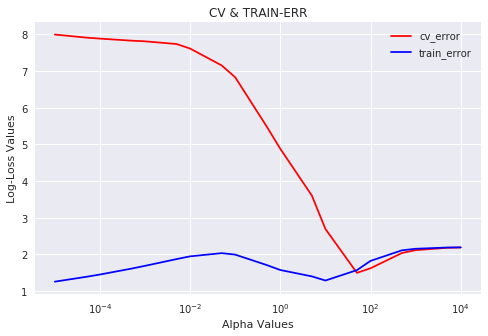

In [154]:
naive_bayes_model('Training', 'OneHotEncode')

Log-Loss for Train-set is : 1.8232850922138717
Log-Loss for Test-set is : 1.5793821612504066
Train Accuracy is : 0.4875215146299484
Test Accuracy is : 0.5461847389558233
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


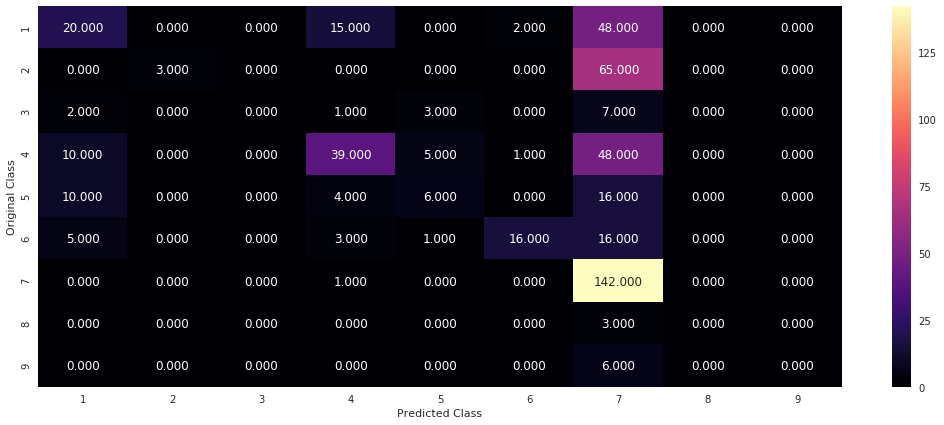

---------------------------------------- PRECISION-MATRIX ----------------------------------------


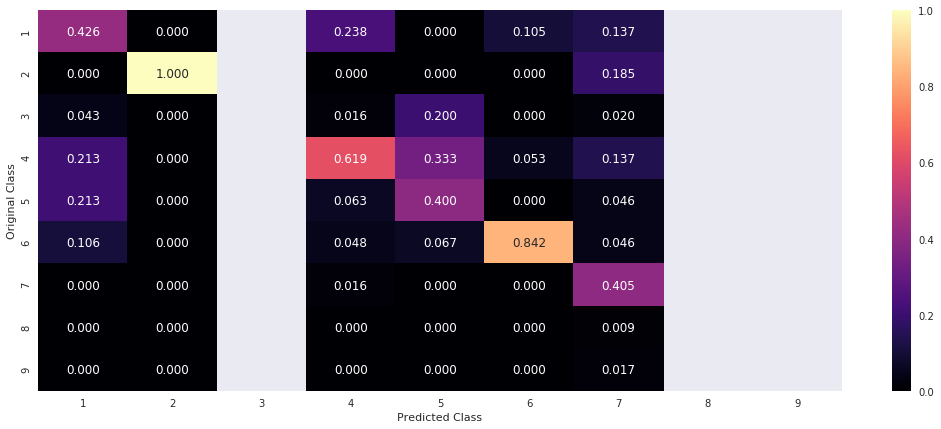

---------------------------------------- RECALL-MATRIX ----------------------------------------


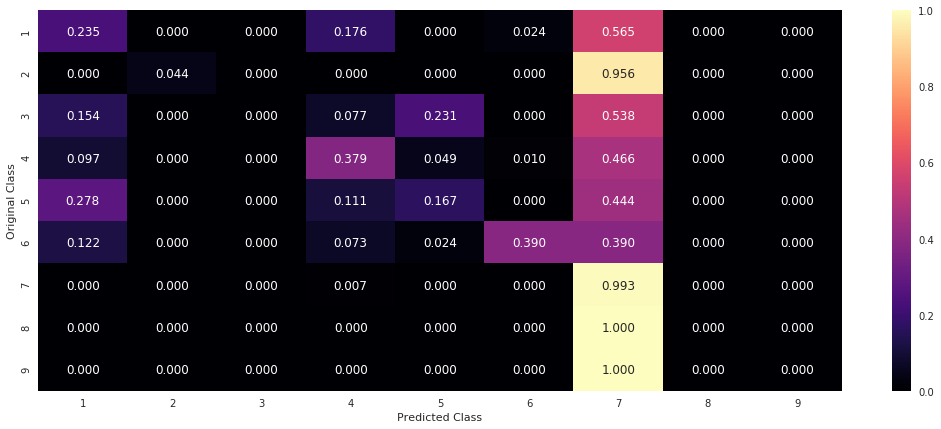

In [156]:
naive_bayes_model('Testing', 'OneHotEncode', 100)

In [115]:
nb_query(100, 1)

Predicted Class :  7
Actual Class :  7
----------------------------------------
Feature from Gene : EGFR 0
Feature from Gene : KIT 0
Feature from Gene : BRAF 0
Feature from Gene : ALK 0
Feature from Variation : Amplification 0
Feature from Gene : FLT3 0
Feature from Gene : KRAS 0
Feature from Gene : ERBB2 0
Feature from Gene : PIK3CA 0
Feature from Gene : PDGFRA 0
Feature from Gene : FGFR2 0
Feature from Gene : CTNNB1 0
Feature from Gene : MTOR 0
Feature from Gene : MAP2K1 0
Feature from Gene : NFE2L2 0
Feature from Gene : MET 0
Feature from TEXT cells 0.04670465404524937
Feature from TEXT activated 0.041993144022132244
Feature from TEXT cell 0.0349754769061881
Feature from TEXT activation 0.076095346341079
Feature from TEXT kinase 0.03525796935230636
Feature from TEXT downstream 0.0469664043237548
Feature from TEXT factor 0.022768953788721104
Feature from TEXT presence 0.03292423472411343
Feature from TEXT contrast 0.04088521224229793
Feature from TEXT phosphorylation 0.06990534269211

### 8.2 KNN

In [104]:
def knn_model(operation, encode_type, best_k = None):
    
    k_val = np.arange(2, 100, 3)
    if operation == 'Training':
        cv_err = []
        train_err = []
        if encode_type == 'OneHotEncode':
            trn_data, cv_data = feature_stack(train_x, train_y, crossv_x, crossv_y, encode_type)
        else:
            trn_data, cv_data = feature_stack(train_x, train_y, crossv_x, crossv_y, encode_type)
        for k in k_val:
            clf = KNeighborsClassifier(n_neighbors = k, n_jobs = -1)
            clf.fit(trn_data, train_y)
            pred_proba_trn = clf.predict_proba(trn_data)
            pred_proba_cv = clf.predict_proba(cv_data)
            train_err.append(log_loss(train_y, pred_proba_trn))
            cv_err.append(log_loss(crossv_y, pred_proba_cv))
        err_compare(train_err, cv_err, k_val, 'K')
    else:
        clf = KNeighborsClassifier(n_neighbors = best_k, n_jobs = -1)
        if encode_type == 'OneHotEncode':
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type)
        else:
            trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, encode_type)
        clf.fit(trn_data, train_y)
        pred_proba_trn = clf.predict_proba(trn_data)
        pred_proba_tst = clf.predict_proba(tst_data)
        trn_err = (1 - clf.score(trn_data, train_y))
        tst_err = (1 - clf.score(tst_data, test_y))
        print('Log-Loss for Train-set is :', log_loss(train_y, pred_proba_trn))
        print('Log-Loss for Test-set is :', log_loss(test_y, pred_proba_tst))
        print('Train Accuracy is :', trn_err)
        print('Test Accuracy is :', tst_err)
        err_metrics(test_y, clf.predict(tst_data))

In [ ]:
knn_model('Training', 'OneHotEncode')

In [136]:
def knn_query(best_k, query_indx):
    trn_data, tst_data = feature_stack(train_x, train_y, test_x, test_y, 'ResponseEncode')
    clf = KNeighborsClassifier(n_neighbors = best_k, n_jobs = -1)
    clf.fit(trn_data, train_y)
    num_feature = 100
    pred_cls = clf.predict(tst_data[query_indx].reshape(1, -1))
    print('Predicted Class : ', pred_cls[0])
    print('Actual Class : ', test_y[query_indx])
    print("-"*40)
    neighbors = clf.kneighbors(tst_data[query_indx].reshape(1, -1), best_k)
    print("The ",best_k," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
    print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Log-Loss for Train-set is : 0.8131886427907048
Log-Loss for Test-set is : 1.5792321261044093
Train Accuracy is : 0.29518072289156627
Test Accuracy is : 0.5200803212851406
---------------------------------------- CONFUSION-MATRIX ----------------------------------------


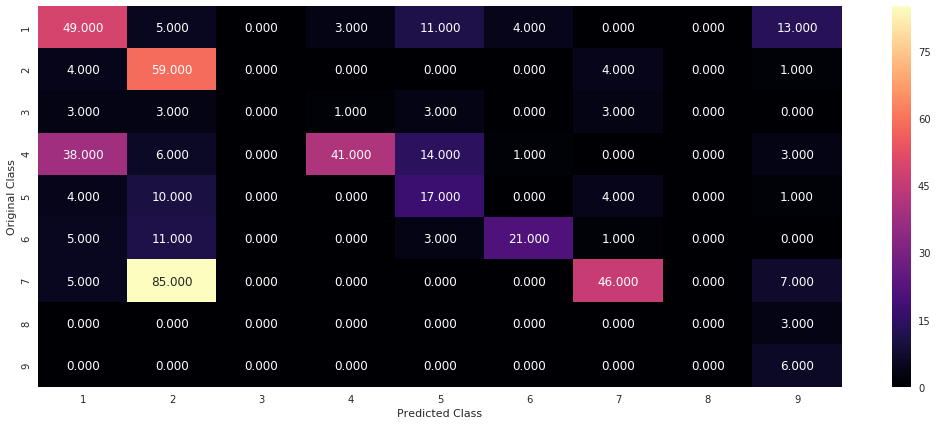

---------------------------------------- PRECISION-MATRIX ----------------------------------------


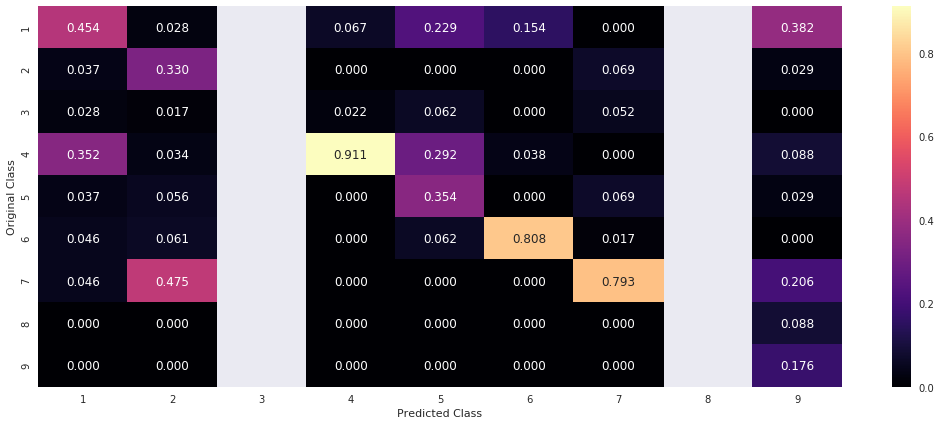

---------------------------------------- RECALL-MATRIX ----------------------------------------


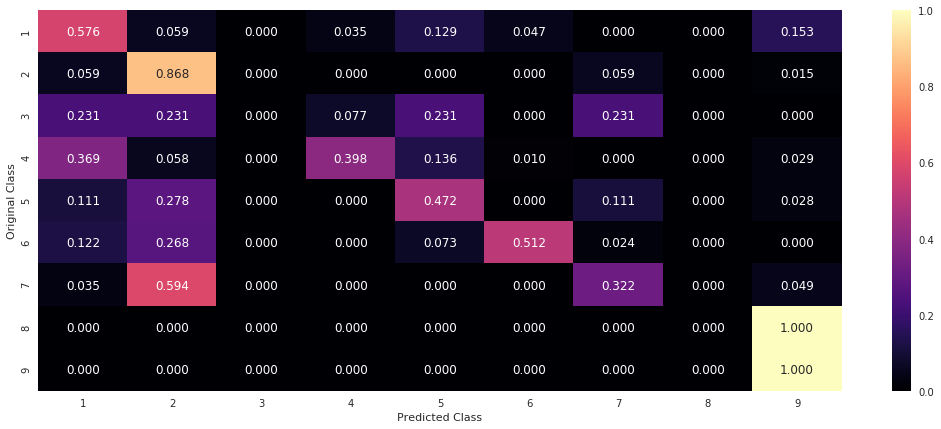

In [138]:
knn_model('Testing', 'ResponseEncode', 80)

In [137]:
knn_query(80, 1)

Predicted Class :  2
Actual Class :  7
----------------------------------------
The  80  nearest neighbours of the test points belongs to classes [2 2 2 7 7 7 4 4 2 4 7 2 4 1 2 2 1 2 2 7 7 2 1 4 3 1 1 4 2 7 7 8 2 2 2 2 8
 7 7 2 2 8 7 1 6 1 2 2 1 1 4 7 2 2 7 2 4 7 7 7 9 9 7 7 3 4 4 7 8 7 7 1 1 4
 4 4 1 6 7 2]
Fequency of nearest points : Counter({2: 23, 7: 22, 4: 13, 1: 12, 8: 4, 3: 2, 6: 2, 9: 2})
